In [72]:
# --------------- MAIN LIBRARIES ------------------
import pandas as pd
import numpy as np
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
#---------------- VECTORIZER ----------------------
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
#Processed text df
train_df = pd.read_csv("train_df_processed.csv")
test_df = pd.read_csv("test_df_processed.csv")
train_df = train_df.dropna()
test_df = test_df.dropna()

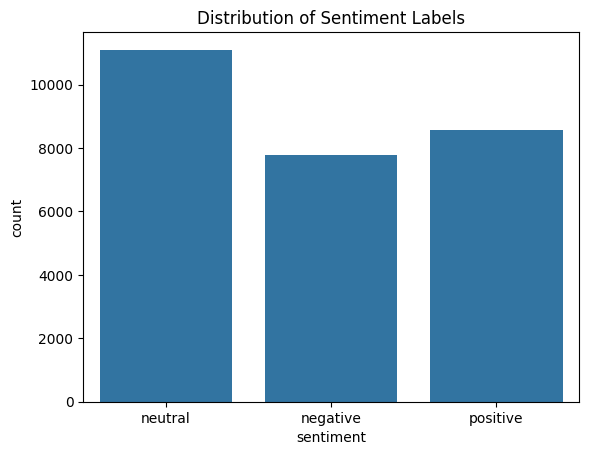

In [74]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [75]:
train_df.head()
train_df.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
processed_text      0
sentiment_class     0
dtype: int64

Vectorization of processed text BoW

In [76]:
#BoW with uni/bi-grams
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
x_train_WoB = vectorizer.fit_transform(train_df["processed_text"])
x_test_WoB = vectorizer.transform(test_df["processed_text"])
vocab_WoB = vectorizer.get_feature_names_out()

In [90]:
def top_terms(counts, vocab, n=20, ngram=None, asc=False):
    df = pd.DataFrame({"term": vocab_WoB, "count": counts})
    if ngram is not None:
        df = df[df["term"].str.count(" ") == ngram - 1]
    df = df.sort_values("count", ascending=asc)
    return df.head(n)

## Top n-grams by "Sentiment" BoW

In [79]:
global_counts = np.array(x_train_WoB.sum(axis=0)).flatten()
topnoneglobal = top_terms(global_counts, vocab_WoB, n=20, ngram=1)
topnbiglobal = top_terms(global_counts, vocab_WoB, n=20, ngram=2)
print("Top unigrams global:\n", topnoneglobal)
print("\nTop bigrams global:\n", topnbiglobal)

Top unigrams global:
          term  count
4549      day   2115
10747      it   2043
8258     good   1578
7501      get   1432
12095    like   1353
7898       go   1280
10156    http   1247
24390    work   1150
25033     you   1148
21728   today   1147
12865    love   1145
8059    going   1103
8457      got   1085
12552     lol   1027
15650     one    998
9147    happy    995
21530    time    965
11486    know    942
17385  really    915
1628     back    914

Top bigrams global:
                 term  count
14234     mother day    358
22511    twitpic com    334
25085         you re    333
10183   http twitpic    332
14243    mothers day    279
9189    happy mother    274
9190   happy mothers    199
11740     last night    181
10159       http bit    180
2297          bit ly    180
8344    good morning    176
21662    tinyurl com    166
10179   http tinyurl    166
3043        can wait    134
24199     wish could    129
5353        don know    118
6575       feel like    112
17812      

In [80]:
# Top WoB for each sentiment
for label in sorted(train_df["sentiment"].unique()):
    mask = (train_df["sentiment"] == label).to_numpy()
    class_counts = np.asarray(x_train_WoB[mask].sum(axis=0)).flatten()
    topuni = top_terms(class_counts, vocab_WoB, n=15, ngram=1)
    topbi = top_terms(class_counts, vocab_WoB, n=15, ngram=2)
    print(f"\nsentiment: {label} | Top unigrams:\n", topuni)
    print(f"\nsentiment: {label} | Top bigrams:\n", topbi)


sentiment: negative | Top unigrams:
          term  count
10747      it    631
12095    like    478
7501      get    436
13858    miss    425
24390    work    403
7898       go    403
18000     sad    397
10368      im    368
19519   sorry    352
2977      can    345
5322      don    345
17385  really    344
21728   today    340
8059    going    334
4549      day    331

sentiment: negative | Top bigrams:
                term  count
6575      feel like     74
22511   twitpic com     63
10183  http twitpic     63
25085        you re     58
11740    last night     52
17812     right now     48
5353       don know     44
19544    sorry hear     41
10159      http bit     38
2297         bit ly     38
5357       don like     36
23346       want go     34
12762    looks like     33
15481         oh no     33
5391      don think     32

sentiment: neutral | Top unigrams:
         term  count
10747     it    748
7501     get    628
10156   http    595
7898      go    582
4549     day    525


In [81]:
color_map = {
    "positive": "#2ca02c",
    "neutral": "#ff7f0e",
    "negative": "#d62728",
}

In [82]:
rows = []
for label in sorted(train_df["sentiment"].unique()):
    mask = (train_df["sentiment"] == label).to_numpy()
    class_counts = np.asarray(x_train_WoB[mask].sum(axis=0)).flatten()

    top20 = top_terms(class_counts, vocab_WoB, n=20, ngram=2, asc=False)
    top20["sentiment"] = label
    rows.append(top20)

plot_df = pd.concat(rows, ignore_index=True)

fig = px.bar(
    plot_df,
    x="count",
    y="term",
    facet_col="sentiment",
    color="sentiment",
    orientation="h",
    height=500,
    width=1200,
    facet_col_spacing=0.08,
    color_discrete_map=color_map
)

fig.update_yaxes(categoryorder="total ascending", showticklabels=True, matches=None)
fig.for_each_yaxis(lambda ax: ax.update(title_text="Bigram"))
fig.update_layout(title="Top 20 bigrams by sentiment", showlegend=False)
fig.show()


In [83]:
rows = []
for label in sorted(train_df["sentiment"].unique()):
    mask = (train_df["sentiment"] == label).to_numpy()
    class_counts = np.asarray(x_train_WoB[mask].sum(axis=0)).flatten()

    top20 = top_terms(class_counts, vocab_WoB, n=20, ngram=1, asc=False)
    top20["sentiment"] = label
    rows.append(top20)

plot_df = pd.concat(rows, ignore_index=True)

fig = px.bar(
    plot_df,
    x="count",
    y="term",
    facet_col="sentiment",
    color="sentiment",
    orientation="h",
    height=500,
    width=1200,
    facet_col_spacing=0.08,
    color_discrete_map=color_map
)

fig.update_yaxes(categoryorder="total ascending", showticklabels=True, matches=None)
fig.for_each_yaxis(lambda ax: ax.update(title_text="Monogram"))
fig.update_layout(title="Top 20 monograms by sentiment", showlegend=False)
fig.show()


Vectorization of processed text tfidf

In [84]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_df=0.9,sublinear_tf=True)
x_train_tfi = vectorizer.fit_transform(train_df["processed_text"])
x_test_tfi  = vectorizer.transform(test_df["processed_text"])
vocab_tfi = vectorizer.get_feature_names_out()

## Top n-grams by "Sentiment" Tidf

In [85]:
global_counts = np.array(x_train_tfi.sum(axis=0)).flatten()
topnoneglobal = top_terms(global_counts, vocab_tfi, n=20, ngram=1)
topnbiglobal = top_terms(global_counts, vocab_tfi, n=20, ngram=2)
print("Top unigrams global:\n", topnoneglobal)
print("\nTop bigrams global:\n", topnbiglobal)

Top unigrams global:
          term       count
4549      day  341.983029
10747      it  305.699653
8258     good  276.388721
24390    work  232.474369
12095    like  228.299037
7501      get  226.353695
7898       go  224.770278
12865    love  216.138624
10156    http  213.894151
25033     you  212.291569
9147    happy  208.947633
21728   today  208.190202
8059    going  207.243397
12552     lol  196.575544
8457      got  196.466707
11486    know  183.512184
21530    time  183.460092
20859  thanks  182.556849
15650     one  182.161134
1628     back  175.711740

Top bigrams global:
                 term      count
14234     mother day  92.451186
22511    twitpic com  86.160848
10183   http twitpic  85.807832
9189    happy mother  77.880537
14243    mothers day  76.755194
25085         you re  74.275261
9190   happy mothers  59.822029
8344    good morning  55.533167
10159       http bit  43.144368
2297          bit ly  43.144368
11740     last night  42.343887
10179   http tinyurl  40.4

In [86]:
# Top WoB for each sentiment
for label in sorted(train_df["sentiment"].unique()):
    mask = (train_df["sentiment"] == label).to_numpy()
    class_counts = np.asarray(x_train_tfi[mask].sum(axis=0)).flatten()
    topuni = top_terms(class_counts, vocab_WoB, n=15, ngram=1)
    topbi = top_terms(class_counts, vocab_WoB, n=15, ngram=2)
    print(f"\nsentiment: {label} | Top unigrams:\n", topuni)
    print(f"\nsentiment: {label} | Top bigrams:\n", topbi)


sentiment: negative | Top unigrams:
          term       count
13858    miss  116.914788
18000     sad   98.282099
10747      it   94.315220
19519   sorry   91.541583
12095    like   77.777233
24390    work   76.000056
1743      bad   73.445484
9251     hate   73.141646
10368      im   69.656380
7501      get   67.130355
7898       go   67.087102
2977      can   66.184005
6551     feel   64.588603
5322      don   64.046424
17385  really   63.846825

sentiment: negative | Top bigrams:
                term      count
6575      feel like  20.550470
19544    sorry hear  16.540089
10183  http twitpic  15.541773
22511   twitpic com  15.524409
17812     right now  13.157899
25085        you re  12.423919
11740    last night  12.254930
5353       don know  11.918225
5357       don like  11.225697
15481         oh no  11.137953
23346       want go   9.905101
12762    looks like   9.708981
3029      can sleep   9.669459
6565      feel good   9.510592
13272     makes sad   9.264071

sentiment: n

In [87]:
color_map = {
    "positive": "#2ca02c",
    "neutral": "#ff7f0e",
    "negative": "#d62728",
}

In [88]:
rows = []
for label in sorted(train_df["sentiment"].unique()):
    mask = (train_df["sentiment"] == label).to_numpy()
    class_counts = np.asarray(x_train_WoB[mask].sum(axis=0)).flatten()

    top20 = top_terms(class_counts, vocab_WoB, n=20, ngram=2, asc=False)
    top20["sentiment"] = label
    rows.append(top20)

plot_df = pd.concat(rows, ignore_index=True)

fig = px.bar(
    plot_df,
    x="count",
    y="term",
    facet_col="sentiment",
    color="sentiment",
    orientation="h",
    height=500,
    width=1200,
    facet_col_spacing=0.08,
    color_discrete_map=color_map
)

fig.update_yaxes(categoryorder="total ascending", showticklabels=True, matches=None)
fig.for_each_yaxis(lambda ax: ax.update(title_text="Bigram"))
fig.update_layout(title="Top 20 bigrams by sentiment", showlegend=False)
fig.show()


In [89]:
rows = []
for label in sorted(train_df["sentiment"].unique()):
    mask = (train_df["sentiment"] == label).to_numpy()
    class_counts = np.asarray(x_train_WoB[mask].sum(axis=0)).flatten()

    top20 = top_terms(class_counts, vocab_WoB, n=20, ngram=1, asc=False)
    top20["sentiment"] = label
    rows.append(top20)

plot_df = pd.concat(rows, ignore_index=True)

fig = px.bar(
    plot_df,
    x="count",
    y="term",
    facet_col="sentiment",
    color="sentiment",
    orientation="h",
    height=500,
    width=1200,
    facet_col_spacing=0.08,
    color_discrete_map=color_map
)

fig.update_yaxes(categoryorder="total ascending", showticklabels=True, matches=None)
fig.for_each_yaxis(lambda ax: ax.update(title_text="Monogram"))
fig.update_layout(title="Top 20 monograms by sentiment", showlegend=False)
fig.show()


## Length of processed text by "sentiment"

In [93]:
df = train_df.copy()
df["n_words"] = df["processed_text"].str.split().str.len()
# Boxplot
fig = px.box(
    df,
    x="sentiment",
    y="n_words",
    color="sentiment",
    points="outliers",
    title="Word count by sentiment"
)
fig.show()

# Histogram
fig = px.histogram(
    df,
    x="n_words",
    color="sentiment",
    nbins=30,
    opacity=0.6,
    barmode="overlay",
    title="Word count distribution by sentiment"
)
fig.show()

## Pairplot by sentiment

In [94]:
cols = ["Population -2020", "Land Area (Km²)", "Density (P/Km²)"]
df_plot = train_df[cols + ["sentiment"]].dropna()
fig = px.scatter_matrix(
    df_plot,
    dimensions=cols,
    color="sentiment",
    opacity=0.6,
    title="Pairplot by sentiment"
)
fig.update_traces(diagonal_visible=False)
fig.show()